- Roll no : MA24M023

- Name : Satheesh D M

This file contains only the solution for Question-2 from the assignment 1.

Request: 

- In case the outputs are not getting displayed. Run this notebook. 

- It should execute all cells in an hour or two. 
- The confuguration given as example is close the best performer and the one took least time.

In [1]:
# torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


In [2]:
# random numbers - seed
import numpy as np
import random

# seed values
seed = 42  # or any number you prefer
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## CNN (VGG-like) class

The following cell contains the definition of the VGG like CNN in PyTorch framework.

Comments :
- I am mentioning it ia VGG like because, I removed removed some convolution layers and came up with this simplified architecture.

- The reason was in usual VGG11 the CIFAR10 (32 x 32) images redues down to (1 x 1) feature maps (only in height and width).

- And the network had many parameters for a 32 x 32 image with 3 channels.
- So I took the liberty to remove some convolution and pooling layers to match closer to the original (height and width) dimension of VGG11 which was 7 x 7.

- In my network the convolution layer output is (8 x 8) for each feature map.
- FC layers are the same as in original VGG11. But output layer has only 10 neurons for obvious reasons. (10 classes).

### Network architecture:

Total layers: (4 convolutions + 2 max pooling + 3 FC)

Convolutional layers:

- Conv1: 3 -> 64 channels, 3x3 kernel, ReLU, output size 32x32

- MaxPool: 2x2 kernel, stride=2, output size 16x16
- Conv2: 64 -> 128 channels, 3x3 kernel, ReLU, output size 16x16
- MaxPool: 2x2 kernel, stride=2, output size 8x8
- Conv3: 128 -> 256 channels, 3x3 kernel, ReLU, output size 8x8
- Conv4: 256 -> 256 channels, 3x3 kernel, ReLU, output size 8x8

Fully connected layers:

- FC1: input size 256 * 8 * 8 (16384), output size 4096, ReLU

- FC2: input size 4096, output size 4096, ReLU
- FC3 (output layer): input size 4096, output size 10 (num_classes)

Activation functions:
- Hidden layers: ReLU

- Output layer: No activation function applied directly — raw logits are returned


### Network output:
- Logits — raw scores for each class, which can be passed through softmax during loss computation.

In [4]:
class VGG(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(VGG, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Conv layer: input channels = 3 (RGB), output channels = 64, 3x3 kernel, padding=1
            # Image size: 32x32 -> 32x32
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            # Max pooling: 2x2 kernel, stride=2
            # Image size: 32x32 -> 16x16
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv layer: input channels = 64, output channels = 128, 3x3 kernel, padding=1
            # Image size: 16x16 -> 16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            # Max pooling: 2x2 kernel, stride=2
            # Image size: 16x16 -> 8x8
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv layer: input channels = 128, output channels = 256, 3x3 kernel, padding=1
            # Image size: 8x8 -> 8x8
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),

            # Conv layer: input channels = 256, output channels = 256, 3x3 kernel, padding=1
            # Image size: 8x8 -> 8x8
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            # No pooling layer — retains 8x8 feature map
        )

        # Fully connected layers
        self.linear_layers = nn.Sequential(
            # Flattened input: 256 channels * 8 * 8 = 16384
            # Linear layer: 16384 -> 4096
            nn.Linear(256 * 8 * 8, 4096),
            nn.ReLU(),

            # Linear layer: 4096 -> 4096
            nn.Linear(4096, 4096),
            nn.ReLU(),

            # Final linear layer: 4096 -> num_classes (10)
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        
        # Flatten the output: (batch_size, 256, 8, 8) -> (batch_size, 16384)
        x = torch.flatten(x, start_dim=1)
        
        # Pass flattened output through fully connected layers
        x = self.linear_layers(x)
        
        return x

## Initialising the model object, loss function and optimiser object.

In [ ]:
# An example configuration is the following

# Model loading and other boilerplate code required to train the model
model = VGG()

# Loss function and optimizer (PyTorch object initialization)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Data preprocessing and loading

This code is executed in 1 cpu core.

In [6]:
# transform the data to tensor and normalize it
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

## Helper function for training

In [7]:
def reset_model(model) -> None :
    """
    Resets the parameters of all layers in the model.
    """
    for layer in model.children():  # Iterate through each child layer of the model
        if hasattr(layer, 'reset_parameters'):  # Ensure the layer has a reset method before calling it
            layer.reset_parameters()  # Reset the layer's weights and biases
    return None

def training(model, loss_func, optimizer, trainloader, testloader, epochs=10, log_file="training_log.txt"):
    """
    Trains a given model using the specified loss function and optimizer.
    Logs training and validation metrics to a file.
    """
    # Reset model weights to ensure training starts from scratch
    reset_model(model)

    # Initialize the log file with CSV-style headers
    with open(log_file, 'w') as file:
        file.write("Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy\n")

    # Lists to track training and validation metrics over epochs
    train_losses = []
    validation_loss = []
    validation_accuracy = []
    train_accuracies = []

    # Main training loop, iterates over the number of epochs
    for epoch in range(epochs):
        running_loss = 0.0  # Accumulate loss over batches
        correct = 0  # Track the number of correct predictions
        total = 0  # Track the total number of samples

        # Training phase - update model weights
        for i, (inputs, labels) in enumerate(trainloader):
            optimizer.zero_grad()  # Zero out gradients from previous step
            outputs = model(inputs)  # Forward pass through the model
            loss = loss_func(outputs, labels)  # Compute loss
            running_loss += loss.item()  # Accumulate batch loss
            loss.backward()  # Backpropagation - compute gradients
            optimizer.step()  # Update weights using optimizer

            # Compute the number of correct predictions in the batch
            _, predicted = torch.max(outputs, dim=1)  # Get class with max score
            correct += (predicted == labels).sum().item()  # Count correct
            total += labels.size(0)  # Count total samples

        # Calculate average training loss and accuracy for the epoch
        avg_loss = running_loss / total
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        # Validation phase - evaluate model without updating weights
        validation_error = 0.0
        total_test = 0
        correct_test = 0
        with torch.no_grad():  # Disable gradient computation for validation
            for i, (inputs_test, labels_test) in enumerate(testloader):
                outputs_test = model(inputs_test)  # Forward pass
                loss_test = loss_func(outputs_test, labels_test)  # Compute loss
                validation_error += loss_test.item()  # Accumulate loss
                total_test += labels_test.size(0)  # Count total test samples

                # Calculate number of correct predictions
                _, predicted_test = torch.max(outputs_test, dim=1)
                correct_test += (predicted_test == labels_test).sum().item()

        # Calculate average validation loss and accuracy for the epoch
        val_loss = validation_error / total_test
        val_accuracy = 100 * correct_test / total_test
        validation_loss.append(val_loss)
        validation_accuracy.append(val_accuracy)

        # Log the epoch metrics to the CSV file
        with open(log_file, 'a') as file:
            file.write(f"{epoch + 1},{avg_loss:.8f},{accuracy:.2f}%,{val_loss:.8f},{val_accuracy:.2f}%\n")

        # Print the progress for real-time tracking
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_loss:.8f}, Train Acc: {accuracy:.2f}%, "
              f"Val Loss: {val_loss:.8f}, Val Acc: {val_accuracy:.2f}%")

    print("Finished Training")

    # Return all tracked metrics for further analysis or plotting
    return train_losses, train_accuracies, validation_loss, validation_accuracy


## Helper function for plotting

In [ ]:
def plot_loss_and_accuracy(train_loss, train_acc, valid_loss, valid_acc):
    import matplotlib.pyplot as plt  # Import Matplotlib for plotting

    # Create a 1x2 grid of subplots (for loss and accuracy)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot training and validation loss curves
    axes[0].grid(True, alpha=0.35, linestyle='-.', color='black', linewidth=0.75)  # Add gridlines for better readability
    axes[0].plot(range(1, len(train_loss) + 1), train_loss, color='red', linestyle='-', linewidth=1, marker='.', label='Training loss')
    axes[0].plot(range(1, len(valid_loss) + 1), valid_loss, color='green', linestyle='-', linewidth=1, marker='.', label='Validation loss')
    axes[0].set_title('Loss Curves', fontsize=16)  # Title of the plot
    axes[0].set_xlabel('Epochs', fontsize=12)       # X-axis label
    axes[0].set_ylabel('Average Loss over an epoch', fontsize=11)  # Y-axis label
    axes[0].legend()  # Add legend

    # Plot training and validation accuracy curves
    axes[1].grid(True, alpha=0.35, linestyle='-.', color='black', linewidth=0.75)
    axes[1].plot(range(1, len(train_acc) + 1), train_acc, color='red', linestyle='-', linewidth=1, marker='.', label='Training Accuracy')
    axes[1].plot(range(1, len(valid_acc) + 1), valid_acc, color='green', linestyle='-', linewidth=1, marker='.', label='Validation Accuracy')
    axes[1].set_title('Accuracy Curves', fontsize=16)
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Average Accuracy over an epoch', fontsize=11)
    axes[1].legend()

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()  # Display the plot

    return None  # Explicit return for clarity

- epchs set to 6. Where the least validation error is encountered.

- the plot below is for 16 epochs.

In [ ]:
# train model
t_loss, t_acc, v_loss, v_acc = training(model, loss_func, optimizer, trainloader,testloader, epochs=6)

# plots (Answer for part 1)
plot_loss_and_accuracy(t_loss, t_acc, v_loss, v_acc)

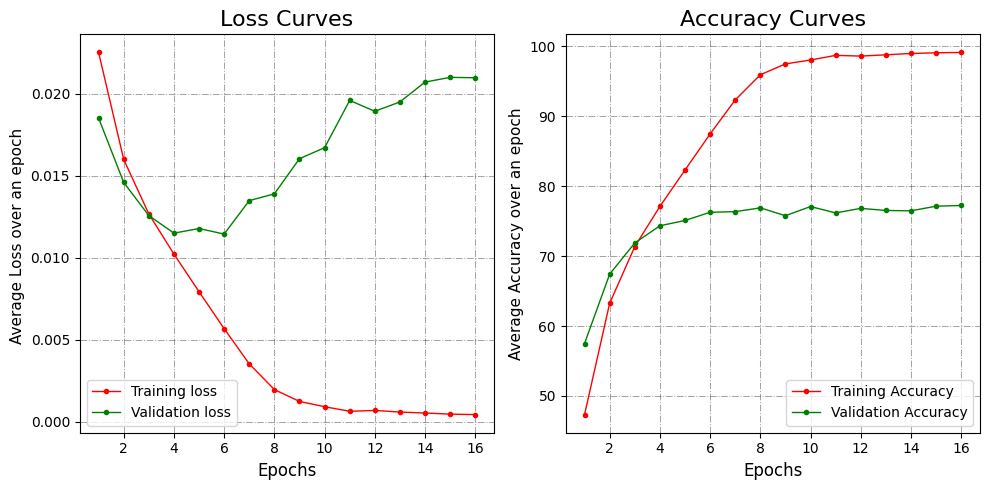

### part - 1 (coonfigurations tested)

- optimizers : SGD, Adam

- mini-batch size : 64

- learning rates : 0.01, 0.001, 0.0001
- epoch ranges : up untill 50 epochs if not converging before. 



### part - 2 (problems while training)



Training Time:

- The VGG-like network had a relatively long training time due to the deep architecture and large number of parameters, especially in the fully connected layers.


Vanishing Gradients:

- Deeper networks like VGG can suffer from vanishing gradient issues, making it harder for the earlier layers to learn effectively, slowing convergence.


Overfitting:

- Without dropout or batch normalization, the network showed signs of overfitting, especially after several epochs, since the fully connected layers have a large number of parameters.
Memory Consumption:

- jupyter notebook kernel crash.

Convergence Speed:

- The lack of batch normalization slowed convergence as internal covariate shift wasn’t mitigated, causing training to be more sensitive to the learning rate.

### part - 3 (plots)

- included withinin the zip folder. (File name suggesting the configuration tested)

- (4 plots) Only those converged were shown (3). And one example of non converging case was included

### part - 4 (validation accuracy)

- Almost all the tested configurations gave a validation accuracy between 73% and 75%. (In which cases convergence was reached within 50 epochs)

- Roughly 7.5 times better than the random guess.

### part - 5 (testing random images from test set)

In [ ]:
import matplotlib.pyplot as plt

## Function to display random test images with true and predicted indices
def display_predictions_with_indices(model, testloader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Get predictions
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # Randomly select num_images to display
    indices = random.sample(range(len(images)), num_images)
    selected_images = images[indices]
    selected_labels = labels[indices]
    selected_preds = preds[indices]

    # Plot images with indices
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        img = selected_images[i].permute(1, 2, 0).cpu().numpy()  # Convert from tensor
        plt.imshow(img)
        plt.title(f'True: {selected_labels[i].item()}\nPred: {selected_preds[i].item()}')
        plt.axis('off')

    plt.show()

# Example usage
display_predictions_with_indices(model, testloader)